# Interpolation of JRA55-do wind speed onto ACCESS-OM2 model grids
- see https://cosima-recipes.readthedocs.io/en/latest/documented_examples/Regridding.html
and https://nbviewer.jupyter.org/github/aekiss/ice_analysis/blob/main/ice_maps.ipynb#Regridders and https://xesmf.readthedocs.io
- ACCESS-OM2 uses the `patch` interpolation method to avoid the stripes in wind stress curl that arise with piecewise constant interpolation - see https://github.com/COSIMA/access-om2/issues/52 and https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html?highlight=patch#Comparison-of-5-regridding-algorithms

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client
import os
import xarray as xr
import xesmf
import climtas.nci

In [2]:
climtas.nci.GadiClient()

Client Scheduler: tcp://127.0.0.1:41691 Dashboard: /proxy/8787/status,Cluster Workers: 20 Cores: 20 Memory: 190.00 GiB


In [3]:
def JRA55_regridder(grid_in, grid_out, method='bilinear', **kwargs): # based on https://nbviewer.jupyter.org/github/aekiss/ice_analysis/blob/main/ice_maps.ipynb#Regridders
    '''Return a function that takes one dataarray argument on grid_in and returns that dataarray regridded onto grid_out.
    
    grid_in -- path to a JRA55-do NetCDF grid file
    grid_out -- path to a MOM grid file (U points are used)
    '''
    weightfn = '_'.join(['regrid', 'weights', os.path.splitext(os.path.basename(grid_in))[0],
                         'to', os.path.splitext(os.path.basename(grid_out))[0], 'U', 'grid', method])+'.nc'
    ds_in = xr.open_dataset(grid_in)
    try: # for /g/data/ik11/grids/ocean_grid_10.nc and /g/data/ik11/grids/ocean_grid_025.nc
        ds_out = xr.open_dataset(grid_out).rename({'xu_ocean': 'x', 'yu_ocean': 'y', 'geolon_c': 'lon', 'geolat_c': 'lat'})
    except ValueError: # for /g/data/ik11/grids/ocean_grid_01.nc - see https://github.com/COSIMA/access-om2/issues/236
        ds_out = xr.open_dataset(grid_out).rename({'grid_x_C': 'x', 'grid_y_C': 'y', 'geolon_c': 'lon', 'geolat_c': 'lat'})
        ds_out_fix = xr.open_dataset('/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output000/ocean/ocean-3d-u-1-monthly-mean-ym_1958_01.nc')\
                    .rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
        ds_out = ds_out.assign_coords({'x': ds_out_fix['x'], 'y': ds_out_fix['y']})

    # make regridder
    rg = xesmf.Regridder(ds_in, ds_out, method=method, reuse_weights=os.path.exists(weightfn), filename=weightfn, **kwargs)

    def outf(da): # define regridding function to output
        outds = rg(da)
        outds.coords['x'] = ds_out['x']
        outds.coords['y'] = ds_out['y']
        return outds.rename({'x': 'xu_ocean', 'y': 'yu_ocean', 'lon': 'longitude', 'lat': 'latitude'})

    return outf

In [13]:
# Define functions to regrid JRA55-do wind data onto each ACCESS-OM2 
JRA55file = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/atmos/3hrPt/uas/gr/v20190429/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_195801010000-195812312100.nc'
JRAto1deg = JRA55_regridder(JRA55file, '/g/data/ik11/grids/ocean_grid_10.nc', method='patch')
JRAto025deg = JRA55_regridder(JRA55file, '/g/data/ik11/grids/ocean_grid_025.nc', method='patch')
JRAto01deg = JRA55_regridder(JRA55file, '/g/data/ik11/grids/ocean_grid_01.nc', method='patch')

## Examples

In [5]:
session = cc.database.create_session()

In [6]:
# Load eastward JRA55-do wind
JRAu = cc.querying.getvar(expt='MRI-JRA55-do-1-4-0', variable='uas', 
                          session=session, frequency='3 hourly',
                          start_time='1957-12-31 22:30:00', 
                          end_time='1958-02-17 04:30:00').isel(time=0)

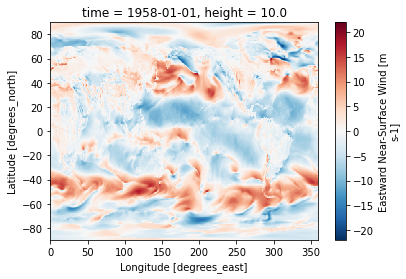

In [7]:
# Plot u on original JRA55-do grid
JRAu.plot()

In [21]:
JRAu

<xarray.DataArray 'uas' (lat: 320, lon: 640)>
dask.array<getitem, shape=(320, 640), dtype=float32, chunksize=(320, 640), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 1958-01-01
  * lat      (lat) float64 -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57
  * lon      (lon) float64 0.0 0.5625 1.125 1.688 ... 357.8 358.3 358.9 359.4
    height   float64 ...
Attributes:
    standard_name:  eastward_wind
    long_name:      Eastward Near-Surface Wind
    comment:        Eastward component of the near-surface wind
    units:          m s-1
    cell_methods:   area: mean time: point
    cell_measures:  area: areacella
    history:        2019-03-07T11:47:57Z altered by CMOR: Treated scalar dime...
    time_bnds:      <xarray.DataArray 'time_bnds' (time: 2920, bnds: 2)>\ndas...

In [8]:
# Regrid JRA u to ACCESS-OM2 1deg grid
u1deg = JRAto1deg(JRAu)

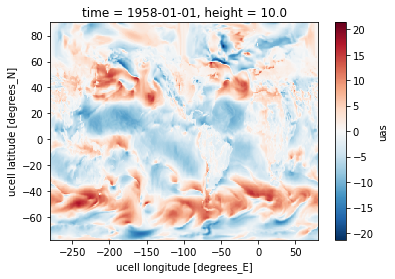

In [9]:
u1deg.plot()

In [20]:
u1deg

<xarray.DataArray 'uas' (yu_ocean: 300, xu_ocean: 360)>
dask.array<transpose, shape=(300, 360), dtype=float64, chunksize=(300, 360), chunktype=numpy.ndarray>
Coordinates:
    time       datetime64[ns] 1958-01-01
    height     float64 ...
    longitude  (yu_ocean, xu_ocean) float32 -279.0 -278.0 -277.0 ... 80.0 80.0
    latitude   (yu_ocean, xu_ocean) float32 -77.75 -77.75 -77.75 ... 65.42 65.0
  * xu_ocean   (xu_ocean) float64 -279.0 -278.0 -277.0 -276.0 ... 78.0 79.0 80.0
  * yu_ocean   (yu_ocean) float64 -77.75 -77.51 -77.26 ... 89.1 89.55 90.0
Attributes:
    regrid_method:  patch

In [11]:
# Regrid JRA u to ACCESS-OM2-025 grid
u025deg = JRAto025deg(JRAu)

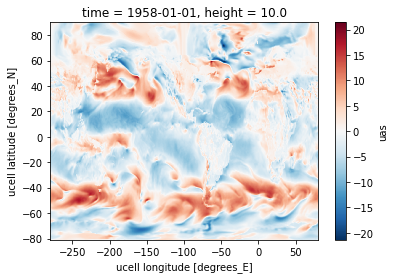

In [12]:
u025deg.plot()

In [19]:
u025deg

<xarray.DataArray 'uas' (yu_ocean: 1080, xu_ocean: 1440)>
dask.array<transpose, shape=(1080, 1440), dtype=float64, chunksize=(1080, 1440), chunktype=numpy.ndarray>
Coordinates:
    time       datetime64[ns] 1958-01-01
    height     float64 ...
    longitude  (yu_ocean, xu_ocean) float32 -279.8 -279.5 -279.2 ... 80.0 80.0
    latitude   (yu_ocean, xu_ocean) float32 -81.02 -81.02 -81.02 ... 65.08 64.97
  * xu_ocean   (xu_ocean) float64 -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yu_ocean   (yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
Attributes:
    regrid_method:  patch

In [16]:
# Regrid JRA u to ACCESS-OM2-01 grid
u01deg = JRAto01deg(JRAu)

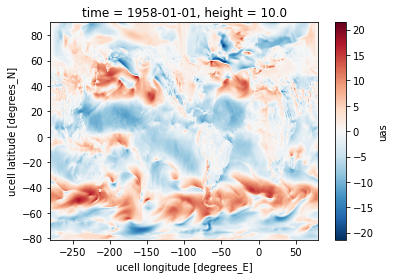

In [17]:
u01deg.plot()

In [18]:
u01deg

<xarray.DataArray 'uas' (yu_ocean: 2700, xu_ocean: 3600)>
dask.array<transpose, shape=(2700, 3600), dtype=float64, chunksize=(2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    time       datetime64[ns] 1958-01-01
    height     float64 ...
    longitude  (yu_ocean, xu_ocean) float64 -279.9 -279.8 -279.7 ... 80.0 80.0
    latitude   (yu_ocean, xu_ocean) float64 -81.09 -81.09 -81.09 ... 65.04 64.99
  * xu_ocean   (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean   (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
Attributes:
    regrid_method:  patch